# Series de tiempo en finanzas
### Entregable clase 1 y 2: Vale para media materia!!

Para aprobar hay que entregar Notebooks con la informacion pedida, comentada para su analisis. 

Notebook Clase 1:
Se pretende el entendimiento de la visualización y curación de una serie de tiempo. 

Notebook Clase 2:
Se pretende estudiar descomposiciones en tendencia, estacionalidad y proceso aleatorio. Usar suavizado exponenciar para predecir la serie de acuerdo a la descomposicion observada.



## Entregable clase 1:

### Exploración de la demanda eléctrica con Python

 ### Problema 1:
 
- Objetivo de este problema: La figura de boxplot de demanda de energía diaria muestra en forma equivocada el eje horario, por lo cual lleva a concluir que de noche la demanda de energia es maxima. Por lo cual es necesario corregirlo. 

- Una forma es modificar la figura, corrigiendo los ejes. Eso deja el resto de la notebook sin modificar (levemente... hay que pasar de dato cada 30 min a dato horario...). 

- La segunda es convertir la zona horaria a Australia/Victoria. Usando **pandas.Series.dt.tz** puede cambiar la zona horaria, como en el siguiente ejemplo



In [ ]:
#ejemplo de código posible.... no chequeado para toda la notebook

datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos['Time'] = datos['Time'].dt.tz_localize('UTC')
datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

- Su tarea es corregir la zona horaria y correr TODA la notebook con esa corrección, verificando que no haya ambiguedades en las definiciones necesarias para plotear las estacionalidades mensuales y semanales. Como la cantidad de datos es muy grande, las estacionalidades se observan via boxplot.

Comenzaremos armando y presentando  el dataset, con el propósito de llegar a poner en evidencia dicho desfasaje de horarios que se está proponiento en el primer entregable. 

In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mediante Pandas leemos la base de datos original. Ya se sabe, de la primer clase, que esta base no cuenta con datos nulos.
La misma, tiene una columna la cual muestra en intervalos de 30 minutos la fecha y la hora a la cual se tomaron las mediciones de consumo electrico de la ciudad de Melburne. Lo que se hará a continuación, será a esta base de datos indexar la misma por un  índice cronológico. 

In [11]:
datos = pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')
datos

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [3]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


Como se puede ver en la tabla anterior, la base de datos comienza en 2011 y finaliza en 2014. Tal como se menciona al comienzo de este entregable, el problema que se tiene es un desfasaje horario entre la hora local de Victoria, Australia y la GMT. Esto quiere decir que para ahorrar esfuerzos y para facilitar la observación de este problema, debemos tomar un pequeño tramo del dataset y presentarlo en escala horaria. 


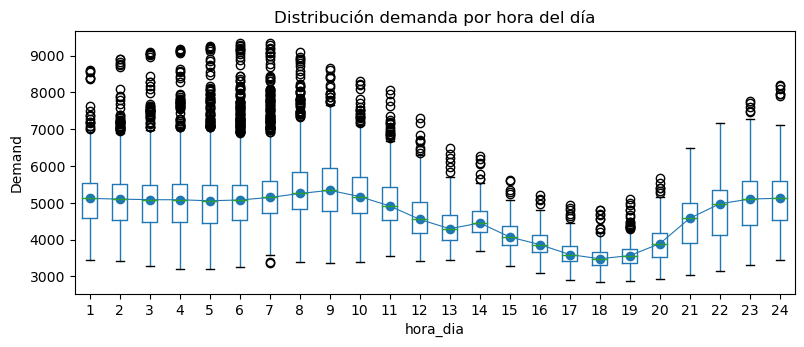

In [4]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

Es visible que la mayor demanda eléctrica se presenta durante  horas de madrugada, donde además se muestan una gran cantidad outliers. Esto nos da un alerta ya que, normalmente, la industria y los ciudadanos suelen ser más activos durante horas de la mañana y la tarno. 
Suponemos que el huso horario que se utilizó para las mediciones, no es el local sinó el estandar GMT +0. 
Veremos ahora de modificar el horario GMT al de Victoria, Australia. 

In [8]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos['Time'] = datos['Time'].dt.tz_localize('UTC')
datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

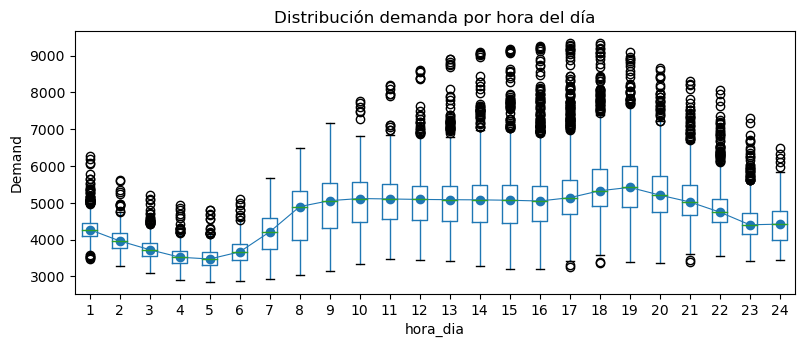

In [9]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

Ahora, como vemos en la nueva gráfica, donde se desplazó el huso horario, podemos apreciar un consumo más acorde, donde los mínimos son durante horas de la madrugada y gradualmente comienzan a crecer en las primeras horas de la mañana hasta llegar a un máximo consumo eléctrico entre las 16 y las 18 h. 

 ### Problema 2:
 
- Objetivo de este problema: Estudiar la demanda mensual. Realice gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb** realice 

- Gráfico de radar

- Gráfico de barra circular

- Gráfico de ploteo radial

Observe que Ud no tiene mas que una serie, por lo cual es como plotear para un solo distrito. 

# Entregable clase 2:

### Exploración de la demanda eléctrica con Python

### Problema 1:
 
- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad de la serie original de demanda horaria,  de la serie de demanda mensual creada en el punto anterior y del zoom de demanda horaria ploteado.  Dar una opinion de lo observado.

A partir del trabajo presentado en clases: Comenzamos por vizualizar la información existente en la base de datos en cuestion

In [14]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos['Time'] = datos['Time'].dt.tz_localize('UTC')
datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')



,Demand,Temperature,Date,Holiday
Time,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False


### Problema 2:
 
- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter para las tres series anteriores y hacer una prediccion de 24 steps (un mes en el caso horario, un año en el caso mensual ). 

- Encontrar los parámetros usando el set de validación y RMSE. 

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST . 

- Pltear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para esta serie. 
